In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from scipy.special import loggamma

In [3]:
from plot_utils.abundance_grouped_heatmaps import add_ticks, custom_percent_formatter
from plot_utils import cool_savefig

In [4]:
simulation_results = np.load('npzfiles/CNBDM_results.018.npz')
droplets = simulation_results['droplets']
batch = droplets[0:10000, :]

In [5]:
zeta = 1

In [6]:
base_relative_abundances = [1e-4, 1e-3, 1e-2]

relative_abundances = [relative_abundance * number
                       for relative_abundance 
                       in base_relative_abundances
                       for number in (1,2,5) 
                       for repeat in range(10)]

relative_abundances += [1-sum(relative_abundances)]
frequencies = np.array(relative_abundances)

In [7]:
S = frequencies.size
rate = 2

In [8]:
%%time
log_fudge_factors = np.sum(rate * frequencies) - np.sum(loggamma(zeta * S * frequencies)) + \
np.sum(zeta * S * frequencies * np.log(zeta * S * frequencies)) + np.sum(
     loggamma((zeta * S * frequencies).reshape((1,-1)) + droplets), axis=1) - \
np.sum( ((zeta * S * frequencies).reshape((1,-1)) + droplets) * (np.log(zeta * S * frequencies + frequencies * rate)).reshape((1,-1)),
axis=1)

CPU times: user 1min 56s, sys: 40 s, total: 2min 36s
Wall time: 2min 37s


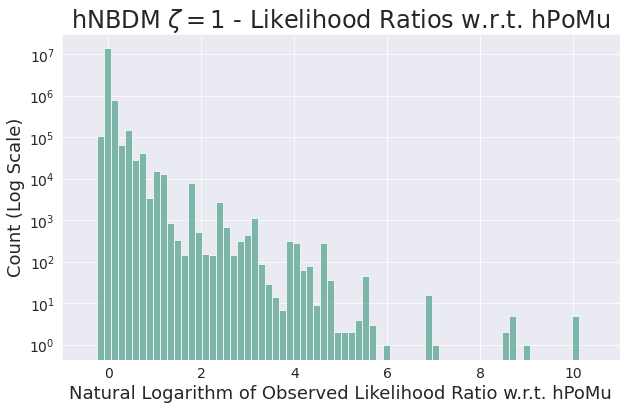

In [9]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    axis = sns.histplot(log_fudge_factors, binwidth=.15, color=sns.color_palette("crest")[1])
    axis.set_yscale("log")
    axis.set_xlim(right=11, left=-1)
    title = 'hNBDM $\zeta=1$ - Likelihood Ratios w.r.t. hPoMu'
    axis.set_title(title, fontsize=24)
    axis.set_xlabel('Natural Logarithm of Observed Likelihood Ratio w.r.t. hPoMu', fontsize=18)
    axis.tick_params(labelsize=14)
    axis.set_ylabel('Count (Log Scale)', fontsize=18)
    cool_savefig(title + ' histogram')

## Grouping Droplets

log likelihood ratio (even when including Robbins terms) for all zero droplets is 0, i.e. they are equally likely under both models -- this makes since, both HPM and HPDM are hierarchical Poisson, so the number of all zero droplets should correspond to an indicator RV of the same Poisson

In [10]:
nonzero_counts = {}
for i in range(9):
    nonzero_counts[i] = np.any((droplets[:,i*10:(i+1)*10] > 0), axis=1)

group_mean_values = np.zeros((9,9))
    
for i in range(9):
    for j in range(i,9):
        relevant_droplet_indices = nonzero_counts[i] & nonzero_counts[j]
        
        fudge = log_fudge_factors[relevant_droplet_indices]
        
        group_mean_values[i,j] = np.mean(fudge)

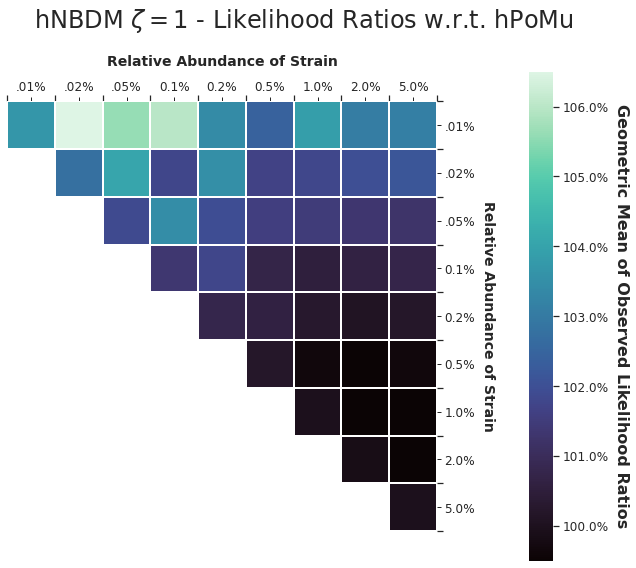

In [11]:
with sns.axes_style("white"), sns.plotting_context("notebook", font_scale=1.1):
    plt.figure(figsize=(11,9))
    ax = sns.heatmap(np.exp(group_mean_values), cmap="mako",
                     mask=np.tril(np.ones((9,9)).astype(bool), k=-1), 
                     cbar_kws={'pad':0.15}, square=True, linewidths=2,
                    linecolor="white", vmin=.995, vmax=1.065)
    ax.yaxis.tick_right()
    ax.xaxis.tick_top()
    add_ticks(ax.xaxis)
    add_ticks(ax.yaxis)
    ax.tick_params(labelsize=20)
    ax.set_xlabel("Relative Abundance of Strain", fontsize=14, labelpad=15, weight="bold")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Relative Abundance of Strain", fontsize=14, labelpad=20, weight="bold",
                 rotation=-90)
    ax.yaxis.set_label_position("right")
    cbar = ax.collections[0].colorbar
    cbar.ax.yaxis.set_major_formatter(custom_percent_formatter)
    cbar.ax.set_ylabel('Geometric Mean of Observed Likelihood Ratios', rotation=-90, 
                       fontsize=16, labelpad=20, weight="bold")
    title = 'hNBDM $\zeta=1$ - Likelihood Ratios w.r.t. hPoMu'
    plt.suptitle(title, fontsize=24)
    cool_savefig(title + ' heatmap')